Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.2579 - val_loss: 0.2615
Epoch 2/10
1/1 [==============================] - 0s 45ms/step - loss: 0.2326 - val_loss: 0.2309
Epoch 3/10
1/1 [==============================] - 0s 68ms/step - loss: 0.2048 - val_loss: 0.2031
Epoch 4/10
1/1 [==============================] - 0s 60ms/step - loss: 0.1824 - val_loss: 0.1779
Epoch 5/10
1/1 [==============================] - 0s 63ms/step - loss: 0.1600 - val_loss: 0.1551
Epoch 6/10
1/1 [==============================] - 0s 61ms/step - loss: 0.1462 - val_loss: 0.1349
Epoch 7/10
1/1 [==============================] - 0s 64ms/step - loss: 0.1208 - val_loss: 0.1173
Epoch 8/10
1/1 [==============================] - 0s 51ms/step - loss: 0.1124 - val_loss: 0.1030
Epoch 9/10
1/1 [==============================] - 0s 43ms/step - loss: 0.0959 - val_loss: 0.0921
Epoch 10/10
1/1 [==============================] - 0s 25ms/step


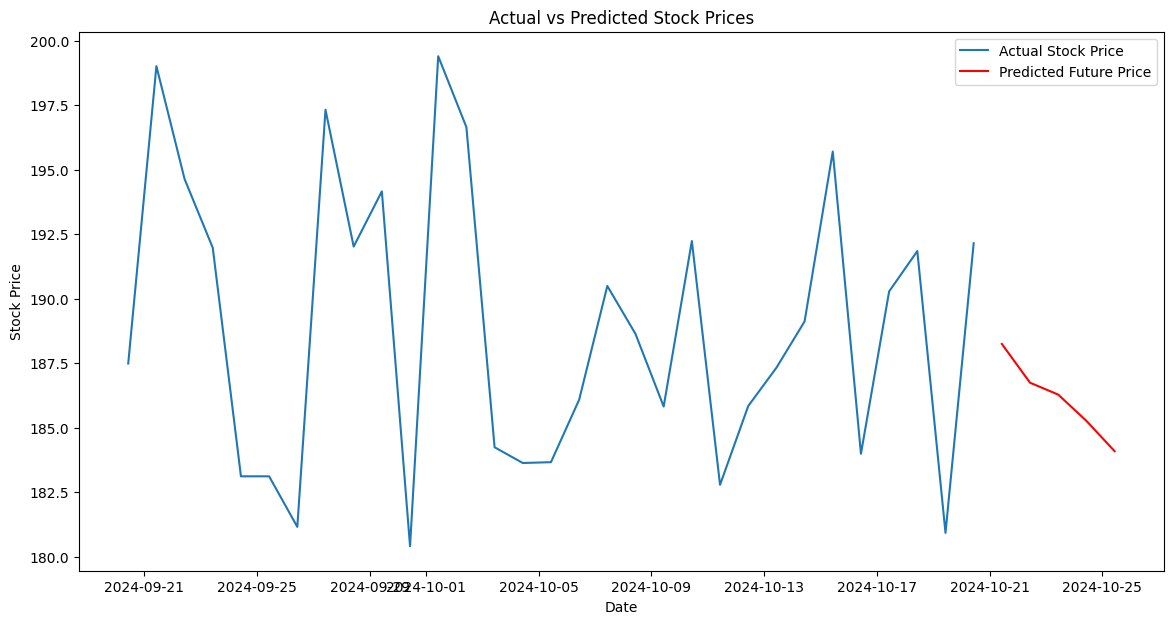

                        Date  Predicted Stock Price
0 2024-10-21 10:23:49.577833             188.249083
1 2024-10-22 10:23:49.577833             186.747663
2 2024-10-23 10:23:49.577833             186.286506
3 2024-10-24 10:23:49.577833             185.268905
4 2024-10-25 10:23:49.577833             184.095034


In [7]:
import numpy as np
import pandas as pd
from newsapi import NewsApiClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Initialize News API and VADER Sentiment Analyzer
newsapi = NewsApiClient(api_key='be43932358024211ad050e5053e4b34e')
analyzer = SentimentIntensityAnalyzer()

# Function to fetch news headlines
def fetch_news_headlines(company_name, from_date, to_date):
    articles = newsapi.get_everything(q=company_name, from_param=from_date, to=to_date, language='en', sort_by='relevancy')
    headlines = [article['title'] for article in articles['articles']]
    return headlines

# Function to calculate sentiment score using VADER
def get_sentiment_score(headlines):
    sentiment_score = 0
    for headline in headlines:
        sentiment = analyzer.polarity_scores(headline)
        sentiment_score += sentiment['compound']
    return sentiment_score / len(headlines) if headlines else 0

# Generate recent dates (last 30 days)
current_date = datetime.now()
date_range = pd.date_range(current_date - timedelta(days=30), current_date).to_pydatetime().tolist()

# Create a DataFrame to hold dates and corresponding sentiment scores
df = pd.DataFrame(date_range, columns=['Date'])
df['Sentiment'] = 0.0

# Fetch news articles and calculate sentiment score for each day
for i in range(len(df)):
    date_str = df['Date'].iloc[i].strftime('%Y-%m-%d')
    headlines = fetch_news_headlines('Apple', date_str, date_str)
    sentiment_score = get_sentiment_score(headlines)
    df.at[i, 'Sentiment'] = sentiment_score

# Simulate stock prices (as we don't have real-time data)
np.random.seed(42)
df['Stock Price'] = np.random.uniform(180, 200, len(df))

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df[['Stock Price', 'Sentiment']])

# Prepare the data for LSTM
X, y = [], []
time_step = 5
for i in range(len(df_scaled) - time_step):
    X.append(df_scaled[i:i + time_step])
    y.append(df_scaled[i + time_step, 0])  # Predicting stock price

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Predict 1 value (stock price)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model
model = create_lstm_model()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict future stock prices
def predict_future(model, recent_data, future_steps):
    future_predictions = []
    input_sequence = recent_data

    for _ in range(future_steps):
        input_sequence_reshaped = np.reshape(input_sequence, (1, input_sequence.shape[0], input_sequence.shape[1]))
        next_price = model.predict(input_sequence_reshaped)
        future_predictions.append(next_price[0, 0])
        next_input = np.append(input_sequence[1:], [[next_price[0, 0], 0]], axis=0)
        input_sequence = next_input

    return future_predictions

# Predict future stock prices based on the last test data
recent_data = X_test[-1]  # Last sequence from test set
future_steps = 5  # Predict the next 5 days

future_stock_prices = predict_future(model, recent_data, future_steps)

# We need to add a dummy column for sentiment since we only want to inverse transform the stock price
dummy_array = np.zeros((len(future_stock_prices), 2))
dummy_array[:, 0] = np.array(future_stock_prices).flatten()

# Inverse transform using both columns (stock price and sentiment)
future_stock_prices = scaler.inverse_transform(dummy_array)[:, 0]  # Only take the stock price (first column)

# Generate future dates
last_date = df['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, future_steps + 1)]

# Create DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Stock Price': future_stock_prices})

# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df['Date'], df['Stock Price'], label='Actual Stock Price')
plt.plot(future_df['Date'], future_df['Predicted Stock Price'], label='Predicted Future Price', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Display the future predictions
print(future_df)
